In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
%matplotlib inline
pd.options.mode.chained_assignment = None

In [143]:
def train_test(df):
    ''' on utilise year == 2022 pour constituer le dataset de test'''
    
    train = df.iloc[75000:106952]
    test =  df.iloc[106952:]
    
    return train, test

In [144]:
def rf_modelisation(x_train, y_train):
    ''' determination des hyperparametre de RF'''
    weights = np.linspace(0.1,0.9,100)
    params = [{
        "n_estimators": [10, 100,150],
        "max_features": [2, 4, 8,10,12],
        "class_weight":[{0:x, 1:1.0-x} for x in weights]
        }]

    rfCV = GridSearchCV(
        RandomForestClassifier(),
        params,
        scoring="recall",
        cv=5,
        n_jobs=-1,
        return_train_score=True)
    
    rfCV = rfCV.fit(x_train, y_train)
    
    return rfCV.best_estimator_

#
def logist_modelisation(x_train, y_train):
    # grille de valeurs
    weights = np.linspace(0.1,0.9,100)

    params = [{"C": [0.01, 0.2, 0.5, 1, 5, 10, 20],
           "penalty": [ "l2"],
           "max_iter": [ 5000],
           "class_weight":[{0:x, 1:1.0-x} for x in weights]
          }]

    logitCV = GridSearchCV(
        LogisticRegression(),
        params,
        scoring="recall",
        cv=5,
        n_jobs=-1,
        return_train_score=True)
    
    logitCV = logitCV.fit(x_train, y_train)
    
    return logitCV.best_estimator_

#
def OneSVM_modelisation(x_train, y_train):
    # grille de valeurs

    params = [{"nu": [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.9], 
              'max_iter': [100,250, 500, 700, 900],
           #"class_weight":[{0:x, 1:1.0-x} for x in weights]
          }]

    outlierCV = GridSearchCV(
        OneClassSVM(),
        params,
        scoring="recall",
        cv=5,
        n_jobs=-1,
        return_train_score=True)
    
    outlierCV = outlierCV.fit(x_train, y_train)
    
    
    return outlierCV.best_estimator_

def DT_modelisation(x_train, y_train):
    # grille de valeurs
    weights = np.linspace(0.1,0.9,100)

    params = [{
        "max_depth": [3, 5, 10, 15,None],
        "min_samples_split": [2, 5, 10,15,20,30],
        "min_samples_leaf": [1, 2, 5,10,30,50],
        "class_weight":[{0:x, 1:1.0-x} for x in weights]
        }]

    dtCV = GridSearchCV(
        DecisionTreeClassifier(),
        params,
        scoring="recall",
        cv=5,
        n_jobs=-1,
        return_train_score=True)
    
    dtCV = dtCV.fit(x_train, y_train)
    
    return dtCV.best_estimator_
  

In [145]:
# Chargement des données
data = pd.read_csv("data/all_features.csv", sep=';',low_memory=False)
label = pd.read_csv("data/descriptif_hiver_ete.csv", sep=';',low_memory=False)
print(len(data))


# definition de train et test 
# definition de x et y 
x_train, x_test = train_test(data.iloc[:,1:])
train_target,test_target = train_test(label)
y_test = test_target['baignade']
y_train = train_target['baignade']


111482


In [146]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

31952
4530
31952
4530


In [101]:
#scaling data
scaler = StandardScaler()
x_train.iloc[:,0:25] = scaler.fit_transform(x_train.iloc[:,0:25])
x_test.iloc[:,0:25] = scaler.fit_transform(x_test.iloc[:,0:25])


In [113]:
## Logistic Regression

model_logist = logist_modelisation(x_train, y_train)
model_logist

LogisticRegression(C=0.01, class_weight={0: 0.1, 1: 0.9}, max_iter=5000)

In [147]:
## decision tree
model_dt = DT_modelisation(x_train, y_train)
model_dt


DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=10)

In [148]:


## Random forest
model_rf = rf_modelisation(x_train, y_train)
model_rf



RandomForestClassifier(class_weight={0: 0.4313131313131313,
                                     1: 0.5686868686868687},
                       max_features=2, n_estimators=10)

In [142]:
import joblib
joblib.dump(model_dt, "saved_models/decision_tree2.joblib")
joblib.dump(model_rf, "saved_models/random_forest2.joblib")
#joblib.dump(model_logist, "saved_models/reg_logist2.joblib")

['saved_models/random_forest2.joblib']

In [118]:
import joblib
joblib.dump(model_logist, "saved_models/reg_logist2.joblib")

['saved_models/reg_logist2.joblib']

# Evaluation

In [140]:

## RF
model_rf.fit(x_train, y_train)

# prediction
y_train_predict = model_rf.predict(x_train)
y_test_predict = model_rf.predict(x_test)

# Evaluation
print("-----------------------Training data-----------------------")
print(classification_report(y_train, y_train_predict))
print("-------------------------Test data-------------------------")
print(classification_report(y_test, y_test_predict))

-----------------------Training data-----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30691
           1       1.00      0.82      0.90       791

    accuracy                           1.00     31482
   macro avg       1.00      0.91      0.95     31482
weighted avg       1.00      1.00      1.00     31482

-------------------------Test data-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3977
           1       1.00      0.91      0.95       553

    accuracy                           0.99      4530
   macro avg       0.99      0.95      0.97      4530
weighted avg       0.99      0.99      0.99      4530



In [71]:
model_logist.fit(x_train, y_train)

# prediction
y_train_predict = model_logist.predict(x_train)
y_test_predict = model_logist.predict(x_test)

# Evaluation
print("-----------------------Training data-----------------------")
print(classification_report(y_train, y_train_predict))
print("-------------------------Test data-------------------------")
print(classification_report(y_test, y_test_predict))

-----------------------Training data-----------------------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     33615
           1       0.18      0.45      0.25       946

    accuracy                           0.93     34561
   macro avg       0.58      0.69      0.61     34561
weighted avg       0.96      0.93      0.94     34561

-------------------------Test data-------------------------
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      2131
           1       0.48      0.77      0.59       398

    accuracy                           0.83      2529
   macro avg       0.72      0.81      0.74      2529
weighted avg       0.88      0.83      0.85      2529



In [124]:
model_logist.fit(x_train, y_train)

# prediction
y_train_predict = model_logist.predict(x_train)
y_test_predict = model_logist.predict(x_test)

# Evaluation
print("-----------------------Training data-----------------------")
print(classification_report(y_train, y_train_predict))
print("-------------------------Test data-------------------------")
print(classification_report(y_test, y_test_predict))

-----------------------Training data-----------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     40536
           1       0.17      0.40      0.24       946

    accuracy                           0.94     41482
   macro avg       0.58      0.68      0.60     41482
weighted avg       0.97      0.94      0.95     41482

-------------------------Test data-------------------------
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3977
           1       0.41      0.52      0.46       553

    accuracy                           0.85      4530
   macro avg       0.67      0.71      0.69      4530
weighted avg       0.87      0.85      0.86      4530



In [63]:
model_dt.fit(x_train, y_train)

# prediction
y_train_predict = model_dt.predict(x_train)
y_test_predict = model_dt.predict(x_test)

# Evaluation
print("-----------------------Training data-----------------------")
print(classification_report(y_train, y_train_predict))
print("-------------------------Test data-------------------------")
print(classification_report(y_test, y_test_predict))

-----------------------Training data-----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106559
           1       0.74      0.10      0.17       393

    accuracy                           1.00    106952
   macro avg       0.87      0.55      0.59    106952
weighted avg       1.00      1.00      1.00    106952

-------------------------Test data-------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      3976
           1       0.00      0.00      0.00       553

    accuracy                           0.88      4529
   macro avg       0.44      0.50      0.47      4529
weighted avg       0.77      0.88      0.82      4529



c:\Users\FABDELLI\python\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FABDELLI\python\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\FABDELLI\python\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
model_dt.fit(x_train, y_train)

# prediction
y_train_predict = model_dt.predict(x_train)
y_test_predict = model_dt.predict(x_test)

# Evaluation
print("-----------------------Training data-----------------------")
print(classification_report(y_train, y_train_predict))
print("-------------------------Test data-------------------------")
print(classification_report(y_test, y_test_predict))

-----------------------Training data-----------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     30691
           1       0.98      0.65      0.78       791

    accuracy                           0.99     31482
   macro avg       0.98      0.83      0.89     31482
weighted avg       0.99      0.99      0.99     31482

-------------------------Test data-------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3977
           1       0.98      0.83      0.90       553

    accuracy                           0.98      4530
   macro avg       0.98      0.91      0.94      4530
weighted avg       0.98      0.98      0.98      4530



In [119]:

df = x_test
df['true_label'] = y_test
df['predicted_label'] = y_test_predict
df

,CE_NCC_0 Arrêt,CE_NCC_1 Marche,CE_chauffage_-1 Arrêt Sécurité,CE_chauffage_-2 Arrêt Manuel OFF,CE_chauffage_1 Marche AUTO,CE_electrolyseur_-5 Arrêt pas de flux,CE_electrolyseur_0 Arrêt,CE_electrolyseur_1 Marche 100%,CE_filtration_-3 Arrêt pause filtration,CE_filtration_0 Arrêt AUTO,...,CE_pompe_chauff_1 Marche AUTO,CE_trait_PH_-5 Arrêt pas de flux chambre analyse,CE_trait_PH_0 Arrêt AUTO,CE_trait_PH_2 En cours pompe active,CE_volet_0 Position ouvert,CE_volet_1 position fermé,airTemp,waterTemp,true_label,predicted_label
106952,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,24.928150,23.852110,0,0
106953,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,24.928150,23.852110,0,0
106954,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,24.928150,23.852110,0,0
106955,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,24.928150,23.852110,0,0
106956,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,24.928150,23.852110,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111477,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,26.104221,23.575230,0,0
111478,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,26.104221,23.575230,0,0
111479,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,26.104221,23.575230,0,0
111480,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,26.104221,23.575230,0,0


In [20]:
from sklearn import metrics
def roc_curves_plot(y_train, pred_proba_train, y_test, pred_proba_test):
    false_positive_rate_train, true_positive_rate_train, _ = metrics.roc_curve(
        y_train, pred_proba_train)
    roc_auc_train = metrics.auc(false_positive_rate_train,
                                true_positive_rate_train)

    false_positive_rate_test, true_positive_rate_test, _ = metrics.roc_curve(
        y_test, pred_proba_test)
    roc_auc_test = metrics.auc(false_positive_rate_test,
                               true_positive_rate_test)

    plt.title('Receiver Operating Characteristic')
    plt.plot(
        false_positive_rate_train,
        true_positive_rate_train,
        'b',
        label='AUC Train = %0.4f' % roc_auc_train)
    plt.plot(
        false_positive_rate_test,
        true_positive_rate_test,
        'g',
        label='AUC Test = %0.4f' % roc_auc_test)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

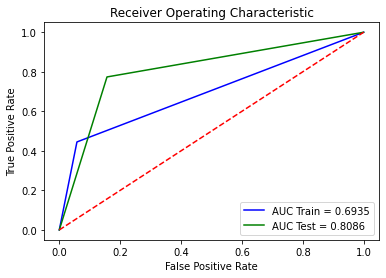

In [72]:
roc_curves_plot(y_train, y_train_predict, y_test, y_test_predict)

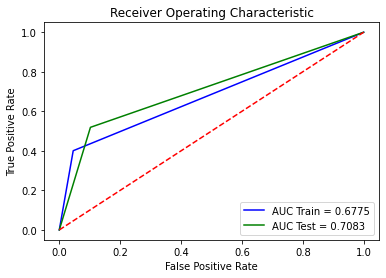

In [125]:
roc_curves_plot(y_train, y_train_predict, y_test, y_test_predict)

In [133]:
accur_train = accuracy_score(y_train, y_train_predict)
precis_train = precision_score(y_train, y_train_predict, average='micro')
rappel_train = recall_score(y_train, y_train_predict, average='micro')
F1_train = f1_score(y_train, y_train_predict, average='micro')

# metrics on test
accur_test = accuracy_score(y_test, y_test_predict)
precis_test = precision_score(y_test, y_test_predict)
rappel_test = recall_score(y_test, y_test_predict)
F1_test = f1_score(y_test, y_test_predict)


print(accur_test )
print(precis_test )
print(rappel_train )
print(F1_test )



0.8514348785871965
0.41354466858789624
0.9416614435176703
0.4603047313552526


In [ ]:


import plotly.express as px


fig = px.line(test1innondation, x=test1innondation[TIME_STEPS:].index, y=scaler.inverse_transform(test1innondation[TIME_STEPS:].innondation),title="data vs pred")
#fig.add_scatter(x=test[TIME_STEPS:].index, y=scaler.inverse_transform(test[TIME_STEPS:].nbtweet), mode='lines',name="test",marker_color='rgba(0, 0, 0, .9)')

fig.add_scatter(x=test_predfreq1innondation.index, y=test_predfreq1innondation[TIME_STEPS:].pred, mode='lines',name="pred1",marker_color='rgba(255, 0, 0, .9)')

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
         
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [ ]:
threshold = []
tpr=[]
fpr=[]
tab_auc_innondation = pd.DataFrame({"threshold": threshold,
                                "tpr":tpr,
                                "fpr":fpr })
tab_auc_innondation

In [ ]:
THRESHOLD = 0.12

test_score_dffreq1innondation = pd.DataFrame(index=test1innondation[TIME_STEPS:].index)
test_score_dffreq1innondation['loss'] = test_mae_lossfreq1innondation
test_score_dffreq1innondation['threshold'] = THRESHOLD
test_score_dffreq1innondation['anomaly'] = test_score_dffreq1innondation.loss > test_score_dffreq1innondation.threshold
test_score_dffreq1innondation['nbtweet'] = test1innondation[TIME_STEPS:].innondation
test_score_dffreq1innondation




import plotly.express as px


fig = px.bar(test_score_dffreq1innondation, x=test_score_dffreq1innondation.index, y="loss")
fig.add_scatter(x=test_score_dffreq1innondation.index, y=test_score_dffreq1innondation['loss'], mode='lines',name="loss",marker_color='rgba(0, 0, 0, .9)')
fig.add_scatter(x=test_score_dffreq1innondation.index, y=test_score_dffreq1innondation['threshold'], mode='lines',name="threshold",marker_color='rgba(255, 0, 0, .9)')
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
         
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()



In [ ]:
anomaliesfreq1innondation = test_score_dffreq1innondation[test_score_dffreq1innondation.anomaly == True]
anomaliesfreq1innondation['nbtweet'] = scaler.inverse_transform(anomaliesfreq1innondation['nbtweet'])
anomaliesfreq1innondation.head(2)




import plotly.express as px

fig = px.line(test1innondation, x=test1innondation[TIME_STEPS:].index, y=scaler.inverse_transform(test1innondation[TIME_STEPS:].innondation) )
fig.add_scatter(x=anomaliesfreq1innondation.index, y=anomaliesfreq1innondation.nbtweet, mode='markers',name="anomalies")
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
         
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()




In [35]:
scaler = StandardScaler()

scaler = scaler.fit(x_test)

x_test = scaler.transform(x_test)

In [36]:
x_test

array([[ 0.06300658, -0.06300658,  0.        , ...,  0.41789955,
         0.10557866,  0.52034908],
       [ 0.06300658, -0.06300658,  0.        , ...,  0.41789955,
         0.10557866,  0.52034908],
       [ 0.06300658, -0.06300658,  0.        , ...,  0.41789955,
         0.10557866,  0.52034908],
       ...,
       [ 0.06300658, -0.06300658,  0.        , ..., -2.39291952,
        -0.55379159, -0.67556049],
       [ 0.06300658, -0.06300658,  0.        , ..., -2.39291952,
        -0.55379159, -0.67556049],
       [ 0.06300658, -0.06300658,  0.        , ..., -2.39291952,
        -0.55010443, -0.43830646]])

In [ ]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
df = assembler.transform(df)
df.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
some_columns_df = data.loc[:,0:25]
features = some_columns_df.columns.tolist()

assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

"""  
Puisque nous avons une bonne idée de l'ensemble de données avec lequel nous travaillons actuellement,
 nous pouvons commencer la transformation des fonctionnalités. La transformation des fonctionnalités 
 signifie la mise à l'échelle, la conversion et la modification des fonctionnalités afin qu'elles puissent
  être utilisées pour former le modèle d'apprentissage automatique afin de faire des prédictions plus précises.
   À cette fin, j'ai utilisé l'indexeur de chaînes et l'assembleur de vecteurs.


Tout d'abord, j'ai utilisé Vector Assembler pour combiner toutes les fonctionnalités dans une seule colonne vectorielle.
 Ici, la nouvelle colonne de vecteur unique est appelée "features".

 Nous avons maintenant sélectionné et transformé nos fonctionnalités, puis nous devons diviser notre ensemble de données en données d'entraînement et de test.
"""


from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'labelIndex')
rfModel = rf.fit(x_train)
predictions = rfModel.transform(x_test)

""" 
Ici featuresCol est la liste des fonctionnalités du Data Frame, ici dans notre cas c'est la colonne features.
 labelCol est la fonctionnalité ciblée qui est baignade. rf.fit(train) adapte le modèle de forêt aléatoire 
 à notre ensemble de données d'entrée nommé x_train. rfModel.transform(test) transforme l'ensemble de données de test. 
 Cela ajoutera de nouvelles colonnes au cadre de données telles que prédiction, et probabilité .
"""

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(x_train)
predictions = dtModel.transform(x_test)

from pyspark.ml.classification import DecisionTreeClassifier

dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtc = dtc.fit(x_train)
pred = dtc.transform(x_test)
pred.show(3)



evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

""" 
Maintenant, nous avons appliqué le classificateur pour nos données de test et nous avons obtenu les prédictions. Ensuite, nous devons évaluer notre modèle.
BinaryClassificationEvaluator est l'évaluateur pour les classifications binaire Puisque nous avons 2 classes (Présence, Absence) La méthode évalue() 
est utilisée pour évaluer les performances du classifieur.
"""

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())   
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(x_train)
predictions = cvModel.transform(x_test)
evaluator.evaluate(predictions)

""" 
Pour évaluer notre modèle et la "grille" correspondante de variables de paramètres, nous utilisons une quintuple validation croisée. 
Cette méthode divise aléatoirement l'échantillon original en cinq sous-échantillons et les utilise pour la formation et la validation.
l'étape de validation croisée joue le role d'un  conteneur pour tester les paramètres que nous venons de définir.
Dans cet exemple, nous attribuons notre pipeline à l'argument estimateur, notre grille de paramètres à l'argument estimatorParamMaps
et nous importons RegressionEvaluator de Spark ML pour l'argument évaluateur.
"""


bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

""" 
L'interprétabilité est très importante dans l'apprentissage automatique. Les acteurs non techniques se contentent rarement de prédictions issues d'une boîte noire.
 Cela oblige les praticiens de l'apprentissage automatique à comprendre quelles fonctionnalités étaient les plus importantes pour les résultats.

Heureusement, Spark ML en tient compte. La fonction featureImportances établit un pourcentage de l'influence de chaque caractéristique sur les prédictions du modèle.

Pour isoler le modèle qui a le mieux fonctionné dans notre grille de paramètres, exécutez littéralement bestModel. Ensuite, sélectionnez l'étape Random Forest dans notre pipeline.
"""


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(x_train)
predictions = dtModel.transform(x_test)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
             
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(x_train)
predictions = cvModel.transform(x_test)
evaluator.evaluate(predictions)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtc = dtc.fit(x_train)
pred = dtc.transform(x_test)
pred.show(3)


In [153]:
data.columns[1]

'CE_NCC_0 Arrêt'